In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')


import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

import diffusion_dist as diff
import dataset as dataset
import model as model
import loss as loss
import train
import TI as ti
import benchmark as bmk

from umap import UMAP

import utils as utils

import post_align as palign
from scipy.sparse import load_npz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.rcParams["font.size"] = 20

results_dir = "results_acc/"

Random seed: 0
running time(sec): 1.1861114501953125
running time(sec): 1.1497483253479004
running time(sec): 1.221101999282837
running time(sec): 1.0676226615905762
running time(sec): 1.1292541027069092
running time(sec): 1.0636639595031738
epoch:  0
	 mmd loss: 0.100
	 ATAC dist loss: 0.320
	 RNA dist loss: 0.142
	 gene activity loss: 5833.602
	 anchor matching loss: 0.000
epoch:  100
	 mmd loss: 0.036
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.011
	 gene activity loss: 17.617
	 anchor matching loss: 0.000
epoch:  200
	 mmd loss: 0.035
	 ATAC dist loss: 0.008
	 RNA dist loss: 0.009
	 gene activity loss: 12.778
	 anchor matching loss: 0.000
epoch:  300
	 mmd loss: 0.034
	 ATAC dist loss: 0.007
	 RNA dist loss: 0.009
	 gene activity loss: 10.035
	 anchor matching loss: 0.000
epoch:  400
	 mmd loss: 0.036
	 ATAC dist loss: 0.007
	 RNA dist loss: 0.008
	 gene activity loss: 8.112
	 anchor matching loss: 0.000
epoch:  500
	 mmd loss: 0.032
	 ATAC dist loss: 0.007
	 RNA dist loss: 0.008
	 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


running Leiden clustering
finished
recovery

relevence

F1 score: 0.31
Kendall-tau score: 0.06
Random seed: 1
running time(sec): 1.174755573272705
running time(sec): 1.160337209701538
running time(sec): 1.209312915802002
running time(sec): 1.0529828071594238
running time(sec): 1.0545291900634766
running time(sec): 1.091299057006836
epoch:  0
	 mmd loss: 0.106
	 ATAC dist loss: 0.331
	 RNA dist loss: 0.161
	 gene activity loss: 5818.587
	 anchor matching loss: 0.000
epoch:  100
	 mmd loss: 0.033
	 ATAC dist loss: 0.011
	 RNA dist loss: 0.011
	 gene activity loss: 17.550
	 anchor matching loss: 0.000
epoch:  200
	 mmd loss: 0.033
	 ATAC dist loss: 0.009
	 RNA dist loss: 0.009
	 gene activity loss: 12.754
	 anchor matching loss: 0.000
epoch:  300
	 mmd loss: 0.034
	 ATAC dist loss: 0.007
	 RNA dist loss: 0.009
	 gene activity loss: 10.030
	 anchor matching loss: 0.000
epoch:  400
	 mmd loss: 0.034
	 ATAC dist loss: 0.006
	 RNA dist loss: 0.008
	 gene activity loss: 8.137
	 anchor matching

KeyboardInterrupt: 

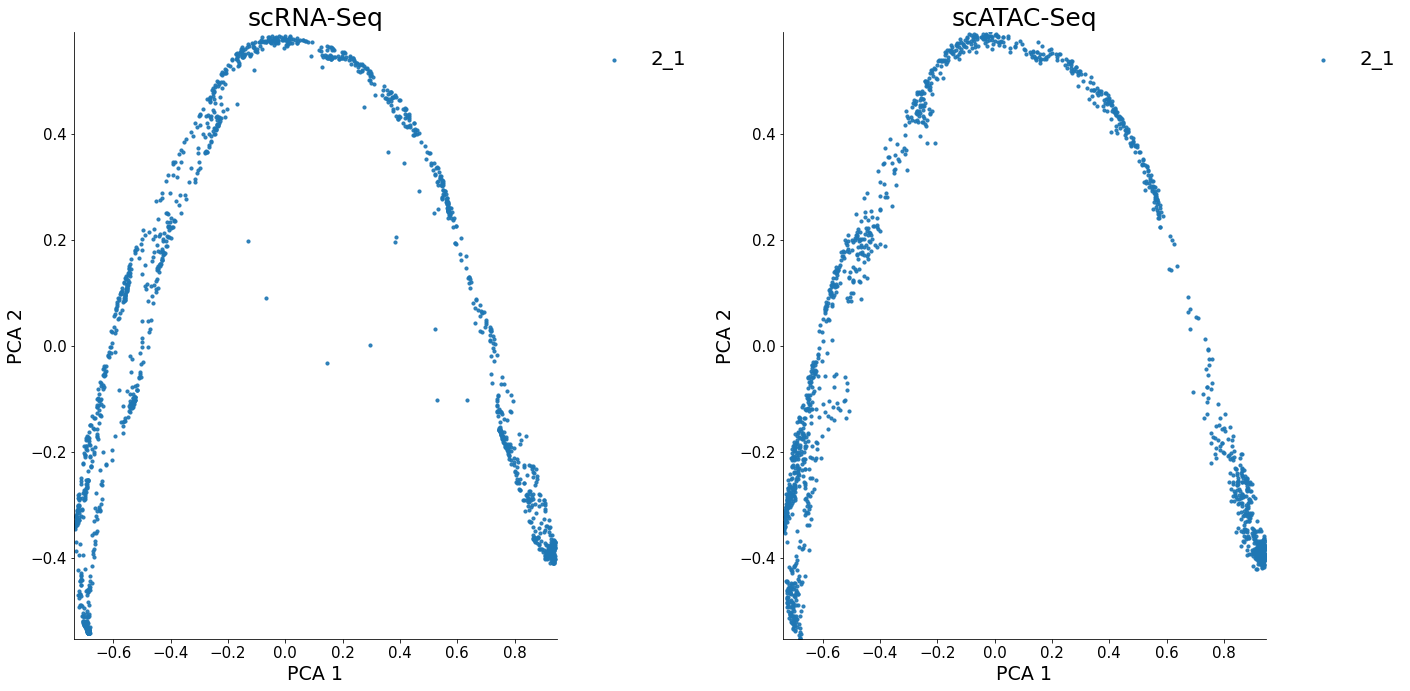

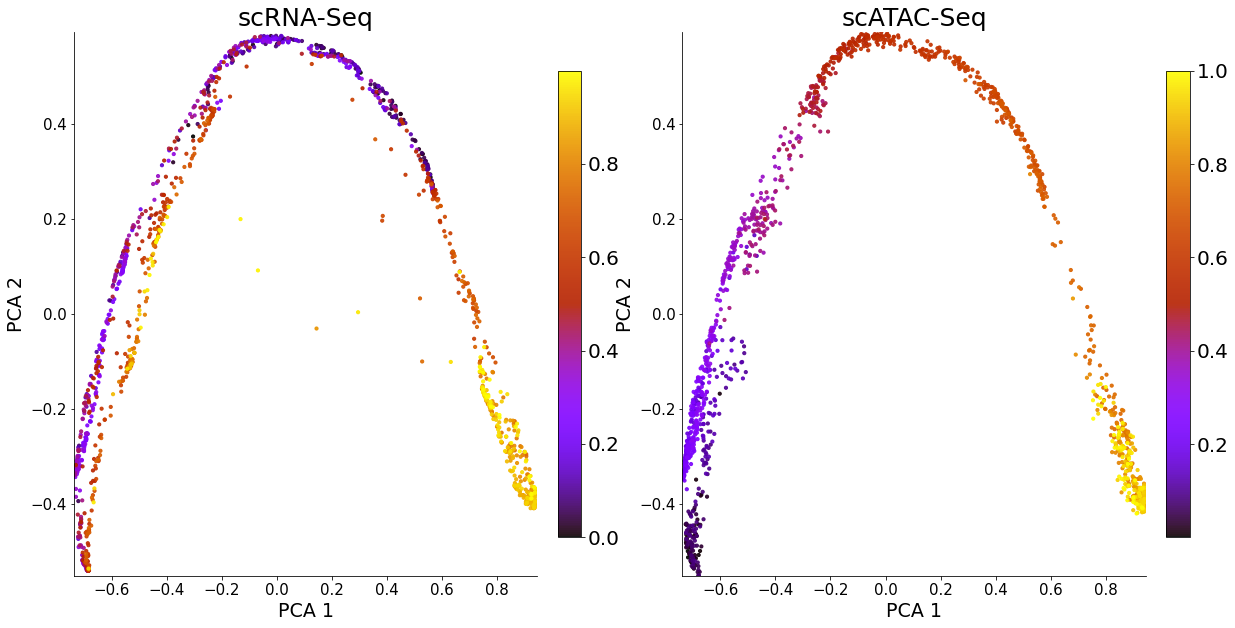

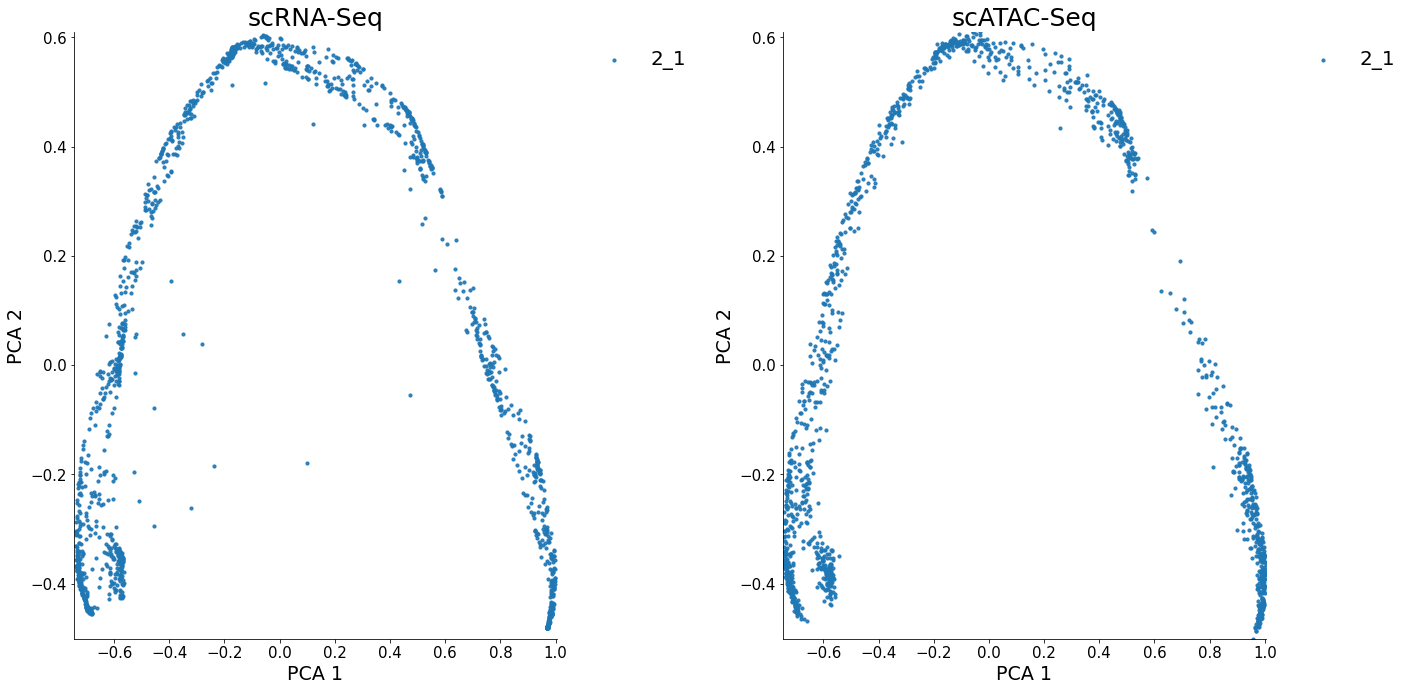

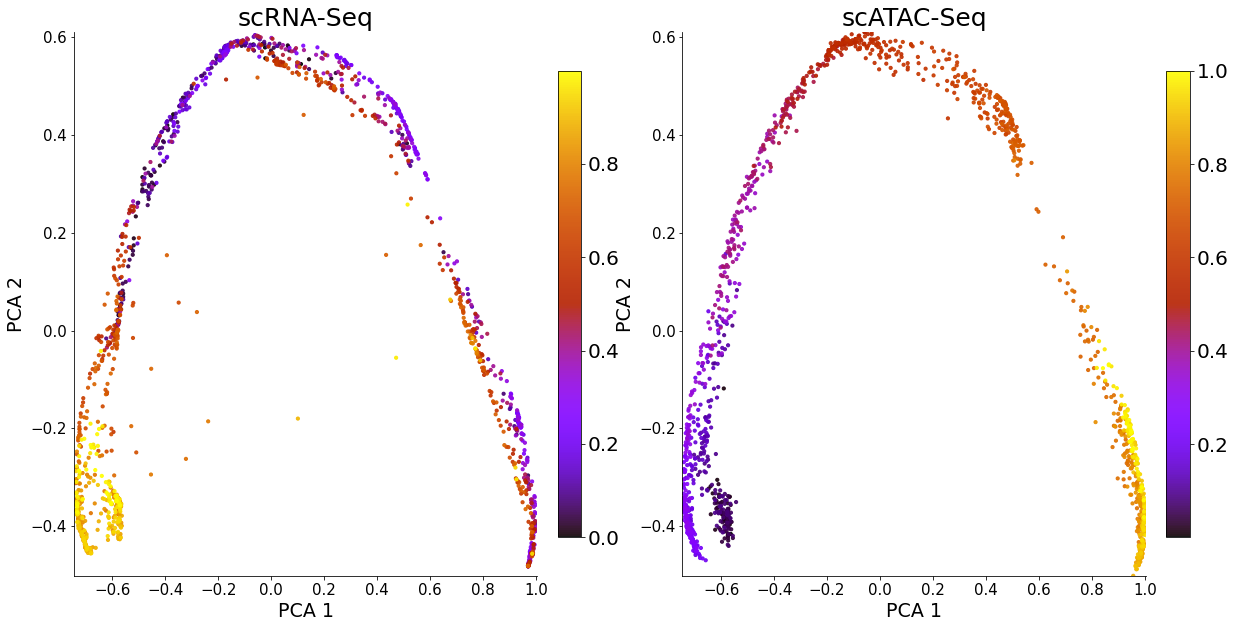

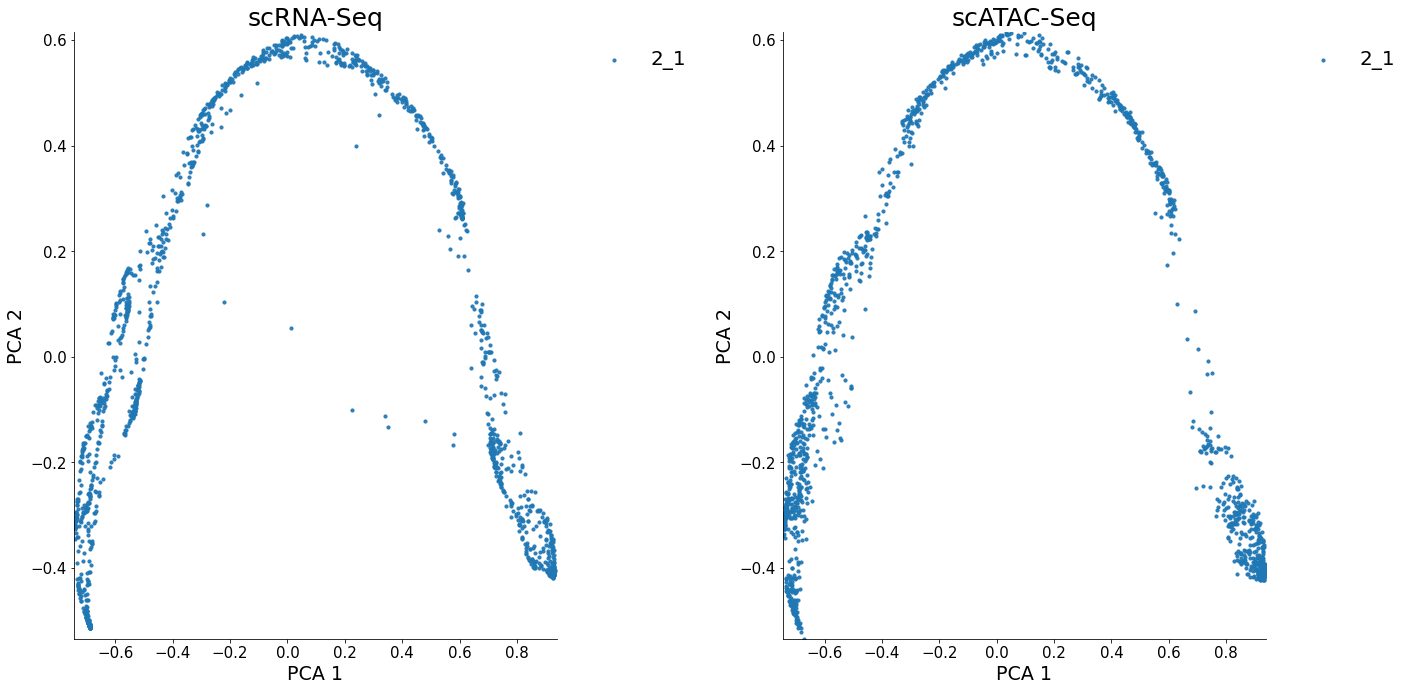

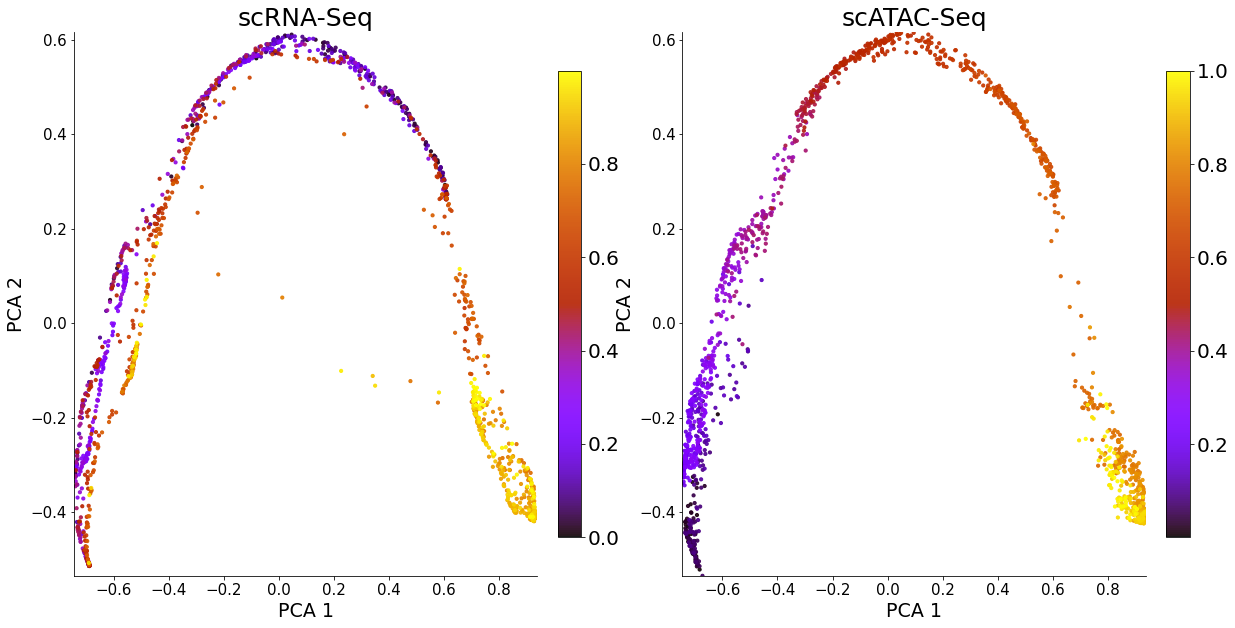

In [2]:
seeds = [0, 1, 2]
latent_dims = [4, 8, 32]
reg_ds = [1, 10]
reg_gs = [0.01, 1, 10]
reg_mmds = [1, 10, 20, 30]

latent_dim = latent_dims[2]
reg_d = reg_ds[0]
reg_g = reg_gs[1]
# harder to merge, need to make mmd loss larger
reg_mmd = reg_mmds[0]

learning_rate = 3e-4
n_epochs = 500
use_anchor = False
ts = [30, 50, 70]
use_potential = True
norm = "l1"


scores = pd.read_csv(results_dir + "scores.csv", index_col = 0)

for data_name in ["lin1", "lin2", "lin3", "lin4", "lin5", "lin6",
                 "bifur1", "bifur2", "bifur3","bifur4", "bifur5", "bifur6",
                 "trifur1", "trifur2", "trifur3","trifur4","trifur5","trifur6"]: 
    if not os.path.exists(results_dir + data_name + "/"):
        print("make directory")
        os.makedirs(results_dir + data_name + "/")
    for seed in seeds:
        print("Random seed: " + str(seed))
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        counts_rna = pd.read_csv("../data/simulated/" + data_name + "/GxC1.txt", sep = "\t", header = None).values.T
        counts_atac = pd.read_csv("../data/simulated/" + data_name + "/RxC2.txt", sep = "\t", header = None).values.T
        label_rna = pd.read_csv("../data/simulated/" + data_name + "/cell_label1.txt", sep = "\t")["pop"].values.squeeze()
        label_atac = pd.read_csv("../data/simulated/" + data_name + "/cell_label2.txt", sep = "\t")["pop"].values.squeeze()
        pt_rna = pd.read_csv("../data/simulated/" + data_name + "/pseudotime1.txt", header = None).values.squeeze()
        pt_atac = pd.read_csv("../data/simulated/" + data_name + "/pseudotime2.txt", header = None).values.squeeze()
        rna_dataset = dataset.dataset(counts = counts_rna, anchor = np.argsort(pt_rna)[:10])
        atac_dataset = dataset.dataset(counts = counts_atac, anchor = np.argsort(pt_atac)[:10])
        coarse_reg = torch.FloatTensor(pd.read_csv("../data/simulated/" + data_name + "/region2gene.txt", sep = "\t", header = None).values).to(device)

        batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)

        train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
        train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

        EMBED_CONFIG = {
            "gact_layers": [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
            "proj_layers": [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
            "learning_rate": learning_rate,
            "n_epochs": n_epochs + 1,
            "use_anchor": use_anchor,
            "reg_d": reg_d,
            "reg_g": reg_g,
            "reg_mmd": reg_mmd,
            "l_dist_type": "kl",
            "device": device
        }

        start_time = time.time()
        # calculate the diffusion distance
        dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "pca", n_components = 30)

        dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                        use_potential = use_potential, dr = "lsi", n_components = 30)

        # quantile normalization
        # dist_atac = diff.quantile_norm(dist_atac, reference = dist_rna.reshape(-1), replace = True)

        dist_rna = dist_rna/np.linalg.norm(dist_rna)
        dist_atac = dist_atac/np.linalg.norm(dist_atac)
        dist_rna = torch.FloatTensor(dist_rna).to(device)
        dist_atac = torch.FloatTensor(dist_atac).to(device)

        # initialize the model
        gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
        encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
        model_dict = {"gene_act": gene_act, "encoder": encoder}

        opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
        opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
        opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

        # training models
        train.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                        data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                        reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                        mode = EMBED_CONFIG["l_dist_type"])
        
        end_time = time.time()
        
        # Plot results
        with torch.no_grad():
            z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
            z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

#         torch.save(model_dict, results_dir + data_name + "/model_" + str(latent_dim) + "_" + str(reg_d) + "_" + str(reg_g) + "_" + str(reg_mmd) + "_" + str(seed) + "_" + norm + ".pth")
#         np.save(file = results_dir + data_name + "/z_rna_" + str(latent_dim) + "_" + str(reg_d) + "_" + str(reg_g) + "_" + str(reg_mmd) + "_" + str(seed) + "_" + norm + ".npy", arr = z_rna)
#         np.save(file = results_dir + data_name + "/z_atac_" + str(latent_dim) + "_" + str(reg_d) + "_" + str(reg_g) + "_" + str(reg_mmd) + "_" + str(seed) + "_" + norm + ".npy", arr = z_atac)
        
        # post-maching
        z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
        z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)
        
        pca_op = PCA(n_components = 2)
        z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
        z_rna_pca = z[:z_rna.shape[0],:]
        z_atac_pca = z[z_rna.shape[0]:,:]

        utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, anno2 = label_atac, 
                          mode = "separate", save = None, 
                          figsize = (20,10), axis_label = "PCA")
        
        utils.plot_latent_pt(z1 = z_rna_pca, z2 = z_atac_pca, pt1 = pt_rna, pt2 = pt_atac, 
                             mode = "separate", save = None, 
                             figsize = (20,10), axis_label = "PCA")
        
        # calculate the diffusion pseudotime
        dpt_mtx = ti.dpt(np.concatenate((z_rna, z_atac), axis = 0), n_neigh = 10)
        pt_infer = dpt_mtx[np.argmin(pt_rna), :]
        pt_infer[pt_infer.argsort()] = np.arange(len(pt_infer))
        pt_infer = pt_infer/np.max(pt_infer)

        pt_true = np.concatenate((pt_rna, pt_atac))
        pt_true[pt_true.argsort()] = np.arange(len(pt_true))
        pt_true = pt_true/np.max(pt_true)
        
        # backbone
        z = np.concatenate((z_rna, z_atac), axis = 0)
        cell_labels = np.concatenate((label_rna, label_atac), axis = 0).squeeze()
        
        groups, mean_cluster, conn = ti.backbone_inf(z_rna, z_atac, resolution = 0.1)
        mean_cluster = np.array(mean_cluster)
        root = groups[np.argmin(pt_infer)]
        G = nx.from_numpy_matrix(conn)
        T = nx.dfs_tree(G, source = root)
        
        # find trajectory backbone
        branching_nodes = [x for x,d in T.out_degree() if (d >= 2)]
        paths = [nx.shortest_path(G, source = root, target = x) for x,d in T.out_degree() if (d == 0)]
        branches = []
        for path in paths:
            last_idx = 0
            for idx, node in enumerate(path):
                if node in branching_nodes:
                    if len(path[last_idx:idx]) > 0:
                        branches.append(path[last_idx:idx])
                        last_idx = idx
            if len(path[last_idx:]) > 0:
                branches.append(path[last_idx:])         
        branches = sorted(list(set(map(tuple,branches))))

        # find cells for all branches
        cell_labels_predict = np.zeros(groups.shape)
        for idx, branch in enumerate(branches):
            for x in branch:
                cell_labels_predict[groups == x] = idx
                
        F1 = bmk.F1_branches(branches = cell_labels, branches_gt = cell_labels_predict)
        kt = bmk.kendalltau(pt_infer, pt_true)

        scores = scores.append({
            "dataset": data_name,
            "model": "scDART", 
            "latent_dim": latent_dim,
            "reg_d": reg_d,
            "reg_g": reg_g,
            "reg_mmd": reg_mmd,
            "norm": norm,
            "seed": seed,            
            "kendall-tau": kt,
            "F1-score": F1,
            "time": end_time - start_time
        }, ignore_index = True)
        print("F1 score: {:.2f}".format(F1))
        print("Kendall-tau score: {:.2f}".format(kt))
        
        torch.cuda.empty_cache()
        del model_dict

# scores.to_csv(results_dir + "scores.csv")
